In [1]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

In [2]:
wine_quality = fetch_ucirepo(id=186)

X = wine_quality.data.features # Preditores

Y = wine_quality.data.targets # Output

# metadata
print(wine_quality.metadata)

print(wine_quality.variables)

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [3]:
df_white = pd.read_csv("./winequality-white.csv", sep=';',index_col=False)
df_white['type'] = 1
df_red = pd.read_csv("./winequality-red.csv", sep=';',index_col=False)
df_red['type'] = 0
df_wine = pd.concat([df_red, df_white], ignore_index=True)
print(f"Dataset carregado: {df_wine.shape[0]} linhas e {df_wine.shape[1]} colunas.")
df_wine

Dataset carregado: 6497 linhas e 13 colunas.


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,1
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,1


Separating the variables X and the target variable y

In [4]:
# Separating our predictors (X) and the target (y) that will be our type of Wine
X_raw = df_wine.drop(['quality', 'type'], axis=1).to_numpy()
y_raw = df_wine['type'].to_numpy()   # 0 = red, 1 = white

Normalization


In [5]:
mean = np.mean(X_raw, axis=0)
std = np.std(X_raw, axis=0)
X_scaled = (X_raw - mean) / std

Adding the intercept

In [6]:
X_final = np.column_stack([np.ones(X_scaled.shape[0]), X_scaled])

Mapping our classes and giving new numbers in order to the qualities

In [8]:
classes = np.unique(y_raw)
n_classes = len(classes)
class_map = {val: i for i, val in enumerate(classes)}
y_mapped = y_raw

Dividing our Train/Test Sets with the proportion of 80 and 20

In [9]:
np.random.seed(42) # We can change this number, I used this to make It reproductible
idx = np.random.permutation(len(X_final))
train_size = int(0.8 * len(X_final))

In [10]:
train_idx, test_idx = idx[:train_size], idx[train_size:]
X_train, X_test = X_final[train_idx], X_final[test_idx]
y_train, y_test = y_mapped[train_idx], y_mapped[test_idx]

## LDA

In [11]:
classes = np.unique(y_train)
n_features = X_train.shape[1]

Measuring the medium of each feature per class

In [12]:
means = {}
for c in classes:
    means[c] = np.mean(X_train[y_train == c], axis=0)

Calculating the Standard Covariance Matrix

In [13]:
cov_comum = np.zeros((n_features, n_features))
for c in classes:
    X_c = X_train[y_train == c]
    n_c = X_c.shape[0]
    cov_comum += (n_c - 1) * np.cov(X_c, rowvar=False)
cov_comum /= (len(y_train) - len(classes))

Calculating the probabilities before

In [14]:
priors = {}
for c in classes:
    priors[c] = len(X_train[y_train == c]) / len(y_train)

Measuring the Inverse Covariance Matrix

In [15]:
inv_cov = np.linalg.inv(cov_comum)

LinAlgError: Singular matrix

As we could see, the matrix is not inversible, so we need to add a little value to the covariance matrix's diagonal to make it inversible

In [16]:
reg_param = 1e-6
cov_estavel = cov_comum + np.eye(n_features) * reg_param

inv_cov = np.linalg.pinv(cov_estavel)

Discriminant Linear Function

$X^T * InvCov * Mean - 0.5 * Mean^T * InvCov * Mean + ln_Prior$

In [17]:
def lda_predict(X):
    predictions = []
    for x in X:
        scores = []
        for c in classes:
            # Formula: x.T * InvCov * Mean - 0.5 * Mean.T * InvCov * Mean + ln(Prior)
            term1 = x.dot(inv_cov).dot(means[c])
            term2 = -0.5 * means[c].dot(inv_cov).dot(means[c])
            term3 = np.log(priors[c])
            scores.append(term1 + term2 + term3)
        predictions.append(classes[np.argmax(scores)])
    return np.array(predictions)

Testing our model

In [18]:
y_pred = lda_predict(X_test)

Now, for our Confusion Matrix and It's analysis...

Accuracy calculus:

In [19]:
accuracy = np.mean(y_pred == y_test)
print(f"Linear Discriminant Analysis (LDA): {accuracy:.2%}")

Linear Discriminant Analysis (LDA): 99.62%


Confusion Matrix:

In [20]:
n_c = len(classes)
conf_matrix = np.zeros((n_c, n_c), dtype=int)
class_to_idx = {val: i for i, val in enumerate(classes)}

for r, p in zip(y_test, y_pred):
    conf_matrix[class_to_idx[r], class_to_idx[p]] += 1

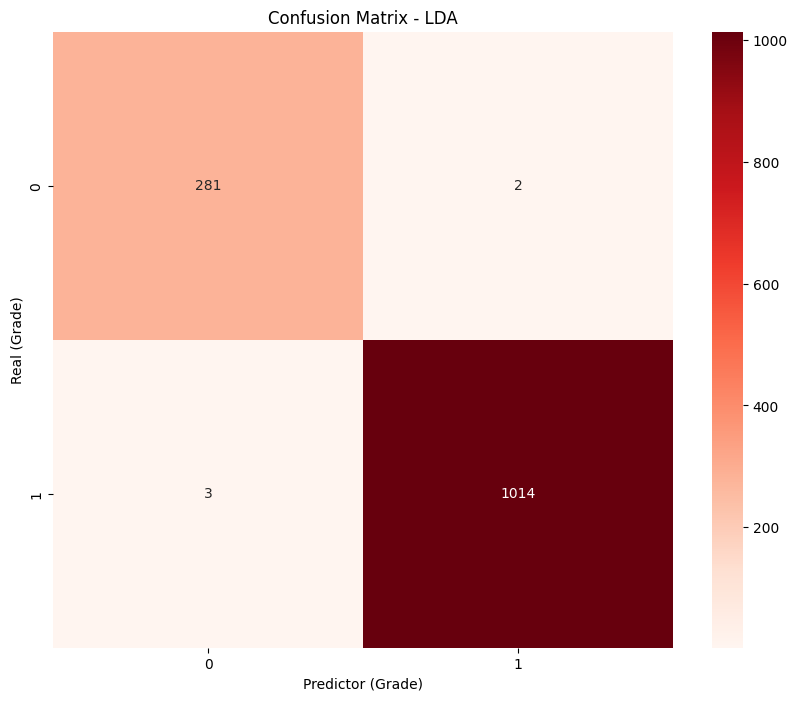

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - LDA")
plt.xlabel("Predictor (Grade)")
plt.ylabel("Real (Grade)")
plt.show()

Within-Class Scatter Matrix (S_W) and Between-Class Scatter Matrix (S_B)

The Within-Class Scatter Matrix $(S_W)$ measures how spread the samples are inside each class. In other words, this factor measures the variance inside each group.

The Between-Class Scatter Matrix $(S_B)$ measures how far apart the class means are from the global mean.

In [30]:
# Sw (within-class scatter)
overall_mean = np.mean(X_train, axis=0)
Sw = np.zeros((n_features, n_features))
for c in classes:
    Xc = X_train[y_train == c]
    for x in Xc:
        d = (x - means[c]).reshape(-1,1)
        Sw += d @ d.T

# Sb (between-class scatter)
Sb = np.zeros((n_features, n_features))
for c in classes:
    Nc = X_train[y_train == c].shape[0]
    d = (means[c] - overall_mean).reshape(-1,1)
    Sb += Nc * (d @ d.T)

eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(Sw) @ Sb)
idx = np.argsort(-eigvals)
W = eigvecs[:, idx[:2]]

Z_train = X_train @ W
Z_test  = X_test  @ W

Now, we are going to catch the features that are more associate to the decision of wine

/tmp/ipython-input-1550557099.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Feature', data=df_importance, palette='coolwarm')


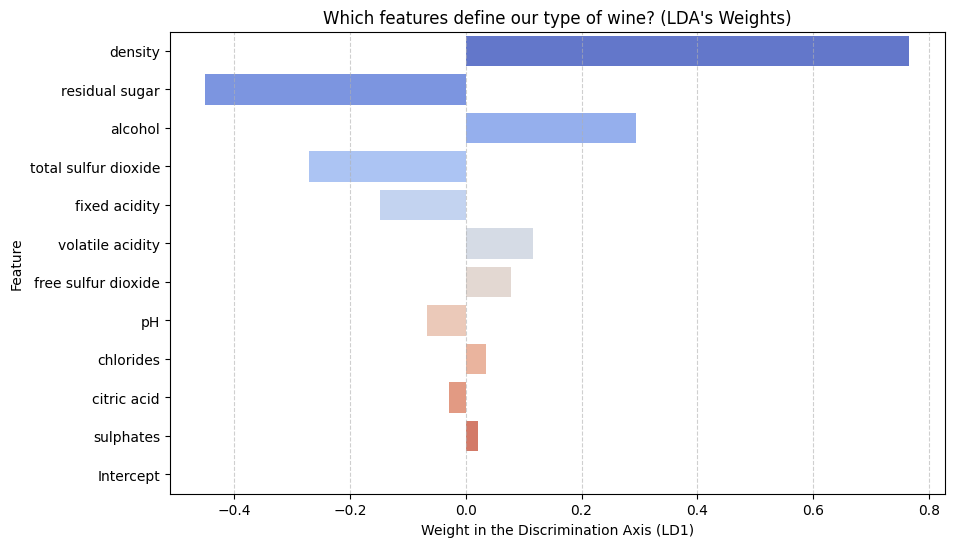

In [35]:
# Catching the names of the collumns
# Interesting, we used the df_wine.drop because X_raw come from there
feature_names = df_wine.drop(['quality', 'type'], axis=1).columns.tolist()
feature_names = ['Intercept'] + feature_names # Adding the Intercept that we added in the X_final

# Extracting the Weights of the LD1
importances = W[:, 0]

# Creating the dataframe
df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Weight': importances.real # It's interesting to note that we used the .real because sometimes the
    # autovectors can have imaginary residuals
})
df_importance['Abs_Weight'] = df_importance['Weight'].abs()
df_importance = df_importance.sort_values(by='Abs_Weight', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Feature', data=df_importance, palette='coolwarm')
plt.title("Which features define our type of wine? (LDA's Weights)")
plt.xlabel("Weight in the Discrimination Axis (LD1)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


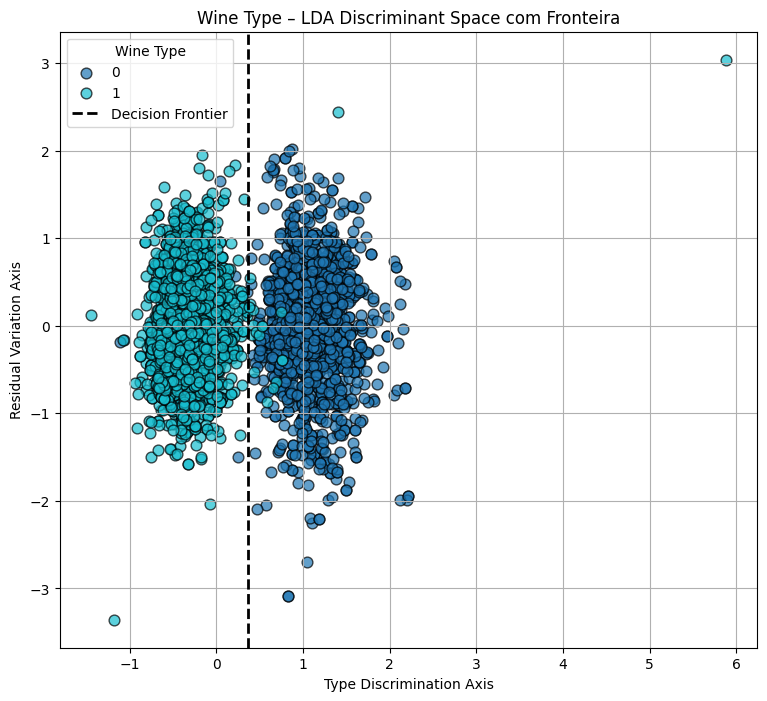

In [36]:
import matplotlib.cm as cm

Z_all = np.vstack([Z_train, Z_test])
y_all = np.concatenate([y_train, y_test])

classes = np.unique(y_all)
colors = cm.tab10(np.linspace(0, 1, len(classes)))

plt.figure(figsize=(9,8))

for i, c in enumerate(classes):
    plt.scatter(
        Z_all[y_all == c, 0],
        Z_all[y_all == c, 1],
        s=60,
        color=colors[i],
        edgecolors="black",
        alpha=0.7,
        label=str(c)
    )

mu0 = np.mean(Z_all[y_all == 0, 0])
mu1 = np.mean(Z_all[y_all == 1, 0])
threshold = (mu0 + mu1) / 2

plt.axvline(x=threshold, color='black', linestyle='--', linewidth=2, label='Decision Frontier')


plt.xlabel("Type Discrimination Axis")
plt.ylabel("Residual Variation Axis")
plt.title("Wine Type – LDA Discriminant Space com Fronteira")
plt.legend(title="Wine Type")
plt.grid()
plt.show()